# Alouette-Data-Availability
***

The following script uses

* *ipyml* : for interative figures (optionnal)
* *pandas* : dataframe structure
* *matplotlib* : plot figures
* *numpy* : mathematical operation and multidimensional array
* *datetime* : manipulate time variables 
* *pycountry* : database for the standard countries
* *urllib* : open url
* *PIL* : image and video tool

The flag images are from [twemoji](https://github.com/twitter/twemoji).


## Data Availability

Alouette-1 is a Canadian satellite in the 60s. It was active for 10+ years, which was quite an achievment at that time. It's also one of the first project with international collaboration with stations over 16 countries. 

The following code helps the user vizualise when the ionograms were taken and by which station. To use the widget *ipympl*, you need to run all the cells. First, let's import the libraries for the script.

In [40]:
# If you don't have ipympl, you can remove this row
%matplotlib ipympl

import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
import pycountry

import urllib
import PIL

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import dates as mdates
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None  # Remove Setting with copy warning in pandas

On our plot, we want to display the flags for each contributing countries of Alouette-1. To do so, we'll need the two following functions.

In [41]:
# Function to import the corresponding flag images
# Parameters :
# country : Name of the country (string)
def get_flag(country):
    if country=='South Africa':
        url = ('https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/'
                'Flag_of_South_Africa_%281982%E2%80%931994%29.svg/'
                '1920px-Flag_of_South_Africa_%281982%E2%80%931994%29.svg.png')
        
    else :
        flagID = {'United States':'1f1fa-1f1f8',
                 'Canada' : '1f1e8-1f1e6',
                 'United Kingdom' : '1f1ec-1f1e7',
                 'Chile' : '1f1e8-1f1f1',
                 'Australia' : '1f1e6-1f1fa',
                 'Ecuador' : '1f1ea-1f1e8',
                 'Spain' : '1f1ea-1f1f8',
                 'Japan' : '1f1ef-1f1f5',
                 'Singapore' : '1f1f8-1f1ec',
                 'Falkland Islands' : '1f1eb-1f1f0',
                 'France' : '1f1eb-1f1f7',
                 'Madagascar' : '1f1f2-1f1ec',
                 'Norway' : '1f1f3-1f1f4',
                 'Peru' : '1f1f5-1f1ea',
                 'Nigeria' : '1f1f3-1f1ec'}
        url = "https://github.com/twitter/twemoji/blob/master/assets/72x72/"+flagID[country]+".png?raw=true"
    
    response = urllib.request.urlopen(url)
    im = np.asarray(PIL.Image.open(response).convert("RGBA"))
    
    return im

# Function to add the flag to the plot
# Parameters :
# coord : Place the add the flag on the y-axis (float)
# country : Name of the country (string)
# ax : Axe with the plot (axe classe)
# startDate : First date on the x-axis (datetime)
def add_image(coord, country, ax, startDate):
    # Get the image
    img = get_flag(country)
    # Adjust the image
    if country=='South Africa':
        z=0.008
    else : z=0.21
    im = OffsetImage(img,zoom=z)
    # Define flag axe
    im.image.axes = ax
    # Add the flag the the plot
    flag = AnnotationBbox(im, (mdates.date2num(startDate), coord),  xybox=(-37., 0.), 
                        frameon=False, xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(flag)

The last function is the one to create the plot. You can customize the plot by choosing the start and end date, the title, the stations, the metadata type and the colors. By default, all stations and all metatype will be plotted.

In [42]:
# Create the plot for data availability per station
# file : result file with the data
# startDate, endDate : string representing a date YYYYMMDD
# title : title of the plot (string)
# stationCode : list of station you want in the plot (list of string) (default='all')
# metaType : list of meta type you want in the plot (list of string) (default='all')
# cmap : name of the color palette for the plot (string)
def availabilityPlot(data,startDate,endDate,title,stationCode='all',metaType='all',cmap='winter_r'):
    
    # Adjust timestamp column
    data['Timestamp']=pd.to_datetime(data['Timestamp'])
    # Filter the data with the dates
    startDate=pd.to_datetime(startDate)
    endDate=pd.to_datetime(endDate)
    subset = data.loc[(data['Timestamp']>=startDate) & (data['Timestamp']<=endDate)]
    
    # Filter the data with the station code
    if (stationCode != None) & (stationCode != 'all') :
        subset = subset.loc[subset['Station_Code'].isin(stationCode)]
    
    if metaType != 'all' :
        subset = subset.loc[subset['processed_image_class'].isin(metaType)]
    
    subset.reset_index(inplace=True) 
    # Count number of times each stations appear in the document (number of measures per station)
    subset['Station_Frequency'] = subset.groupby('Station_Code')['Station_Code'].transform('count')
    
    # We are only interested in the days, not the hours so we normalize the dates
    subset['Timestamp']=subset['Timestamp'].dt.normalize()
    # For a smaller dataframe, we drop the duplicates
    subset.drop_duplicates(inplace=True)
    subset.sort_values('Station_Frequency', inplace=True, ascending=True)
    
    # Add dates Covered and Not covered by any station
    # Extract the covered dates and sort them
    covered = pd.DataFrame()
    covered['Timestamp'] = subset['Timestamp'].unique()
    if stationCode != None :
        covered['Days_with_data'] = np.repeat('Days with data',len(covered))
    else:
        covered['Days_with_data'] = np.repeat(0.5,len(covered))    
    covered.sort_values(by='Timestamp',inplace=True,ascending=True,ignore_index=True)
    
    # Create empty dataframe
    notcovered = pd.DataFrame(columns=['Timestamp','Days_without_data'])
    # One day measure
    oneday = datetime.timedelta(days=1)
    # For all dates covered
    for i in range(len(covered)-1):
        # Create temporary dataframe
        toadd = pd.DataFrame(columns=['Timestamp','Days_without_data'])
        # Calculate number of days between two dates covered
        interval = (covered['Timestamp'][i+1]-covered['Timestamp'][i])/np.timedelta64(1, 'D')
        # If there's more than one day between two consecutive dates
        if interval > 1. :
            # Add the dates between as not covered
            toadd['Timestamp'] = pd.date_range(covered['Timestamp'][i]+oneday,covered['Timestamp'][i+1]-oneday)
            if stationCode != None :
                toadd['Days_without_data'] = np.repeat('Days without data',len(toadd))
            else:
                toadd['Days_without_data'] = np.repeat(0,len(toadd))
            notcovered = pd.concat([notcovered,toadd],ignore_index=True)  
    
    # Create figure
    fig, ax = plt.subplots()
    fig.suptitle(title)
    # The padding of the figure, we need enough space for the title, colorbar and the station name on the left
    fig.subplots_adjust(top=0.93,bottom=0.2, left=0.3)
    
    # Plot the data availability
    ax.scatter(notcovered['Timestamp'],notcovered['Days_without_data'],marker='|',linewidth=0.7, color='grey')
    ax.scatter(covered['Timestamp'],covered['Days_with_data'],marker='|',linewidth=0.7, color='black')

    if stationCode != None :
        plot = ax.scatter(subset['Timestamp'],subset['Station_Name'],c=subset['Station_Frequency'],
                          cmap=cmap,marker='|',linewidth=0.7)
        # Add the colorbar
        cax=fig.add_axes([0.34, 0.067, 0.5, 0.03]) # Colorbar axe
        cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
        cbar.set_label('Number of ionograms between '+startDate.strftime('%Y-%m-%d')+' and '+endDate.strftime('%Y-%m-%d'))
        
        # Add flags
        # Create new dataframe
        stationName = pd.DataFrame()
        # Add the station name and the country for each station
        stationName['Station_Name'] = subset['Station_Name']
        stationName['Country'] = subset['Country']
        # Drop the duplicates to only have each station one time
        stationName.drop_duplicates(inplace=True, ignore_index=True)

        # Add the flags to the plot
        if len(notcovered)==0 :
            a = 1
        else :
            a = 2
        for i, c in enumerate(stationName['Country']):
            add_image(i+a, c, ax, startDate)
        
    else :
        ax.set_yticks([0,0.5])
        ax.set_yticklabels(['Days without data','Days with data'])
        ax.set_ylim(-0.15,0.65)
    
    # Add grid and adjust the x and y ticks
    ax.grid(which='major',axis='x',alpha=0.7,lw=0.7,ls='-')
    ax.grid(which='minor',axis='x',alpha=0.7,lw=0.5,ls='--')
    ax.tick_params(which='major',axis='x',labelrotation=90)
    ax.tick_params(which='major',axis='y', pad=26)
    
    # Add the text box for overall days covered
    date_only = subset['Timestamp']
    # The number of unique dates divided by the number of total days
    nbdays = int((endDate-startDate).days+1)
    per = len(date_only.unique()) / nbdays * 100
    text = '% of days with data : '+ "%.2f" % per +'%'
    box = dict(boxstyle='round,pad=0.5', alpha=0.5)
    fig.text(0.13, 0.075, text, va='bottom',bbox=box)
    
    # Custom x ticks
    interval = int((endDate-startDate)/np.timedelta64(1, 'M'))
    # x ticks vary depending on the interval of time between the start and end dates
    if(interval<=6):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='W'),minor=False)
    elif(interval<=18):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='MS'),minor=False)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='SMS'),minor=True)
    elif(interval<=36):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='MS'),minor=True)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='2MS'),minor=False)
    elif(interval<=60):
        xmajor = pd.date_range(startDate,endDate,freq='4MS')
        ax.set_xticks(xmajor, minor=False,)
        ax.set_xticklabels(xmajor.strftime('%Y-%m'), minor=False)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='2MS'),minor=True)
    else:
        xmajor=pd.date_range(str(startDate.year)+'0701',str(endDate.year)+'0701',freq='6MS')
        ax.set_xticks(pd.date_range(startDate,endDate,freq='QS'),minor=True)
        ax.set_xticklabels(xmajor.strftime('%Y-%m'), minor=False)
        ax.set_xticks(xmajor,minor=False)
    
    return(fig)

To add the flags to the plot, we need to add a column to the result_master.csv file with each station's country.

In [43]:
df = pd.read_csv('L:/DATA/Alouette_I/Total/05_result/result_master.csv',
                   usecols=['Timestamp','Station_Code','Station_Name','processed_image_class'])

In [44]:
# Create empty list
countries = []
# Create a list of station
stationList = df['Station_Name'].unique().tolist()

# For each station, check which country is in the name
for station in stationList :
    for country in pycountry.countries:
        if (country.name in station) | (country.alpha_3 in station):
            countries.append(country.name)

# Some adjustments because some countries are not detected or are not exactly what we want 
# This one was added because in "Nigeria" there's "Niger"
countries.remove('Niger') 
# Falkland Islands is not provided by pycountry
countries.insert(stationList.index('Falkland Islands (Islas Malvinas)'),'Falkland Islands')
# An acronym is used for United Kingdom so it wasn't detected
countries.insert(stationList.index('Winkfield, England, UK'),'United Kingdom')
# The Antarctica station was operated by the US
countries[countries.index('Antarctica')]='United States'

# Create the country column
df['Country']=''
for i,station in enumerate(stationList) :
    idx = np.where(df['Station_Name']==station)
    df['Country'][idx[0]] = countries[i]
df.head(10)

,processed_image_class,Timestamp,Station_Code,Station_Name,Country
0,dot,1962-09-29 00:00:00,COL,"College, Fairbanks, AK, USA",United States
1,dot,1962-09-29 00:00:00,COL,"College, Fairbanks, AK, USA",United States
2,dot,1962-09-29 00:00:00,COL,"College, Fairbanks, AK, USA",United States
3,dot,1962-09-29 00:00:00,OTT,"Ottawa, Canada",Canada
4,dot,1962-09-29 00:00:00,COL,"College, Fairbanks, AK, USA",United States
5,dot,1962-09-29 00:00:00,COL,"College, Fairbanks, AK, USA",United States
6,dot,1962-09-29 07:13:27,OTT,"Ottawa, Canada",Canada
7,dot,1962-09-29 07:14:13,COL,"College, Fairbanks, AK, USA",United States
8,dot,1962-09-29 07:17:52,OTT,"Ottawa, Canada",Canada
9,dot,1962-09-29 22:06:00,COL,"College, Fairbanks, AK, USA",United States


Before using our fonction, here's a list of the possible station codes and metadata types you can enter as parameters.

#### Metadata types
* dot : dots on the side of ionograms
* num : numbers on the side of ionograms
* num2 : numbers at the bottom of ionograms

#### Stations
| **Station Code** | Station Name | **Station Code** | Station Name |**Station Code** | Station Name |
|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|
|**ANT**|Antofagasta, Chile|**JOB**|Johannesburg, South Africa|**RAL**|Orroral Valley, Australia|
|**BAT**|Byrd Station, Antarctica|**KJP**|Kashima, Japan|**RES**|Resolute Bay, NT, Canada|
|**BFR**|Bretigny, France|**KNO**|Kano, Nigeria|**ROS**|Rosman, NC, USA|
|**BLR**|Boulder, CO, USA|**LIM**|Lima, Peru|**SNP**|Singapore|
|**BPT**|Blossom Point, MD, USA|**MAD**|Tananarive, Madagascar|**SNT**|Santiago, Chile|
|**COL**|College, Fairbanks, AK, USA|**MOJ**|Mojave, CA, USA|**SOL**|Falkland Islands (Islas Malvinas)|
|**DAR**|Darwin, Australia|**NEW**|St. John's, NL, Canada|**SPT**|South Point, HI, USA|
|**FTM**|Fort Myers, FL, USA|**OTT**|Ottawa, Canada|**TRO**|Tromso, Norway|
|**GIL**|Gilmore Creek, Fairbanks, AK, USA|**PCI**|Las Palmas, Canary Islands, Spain|**ULA**|University of Alaska, Fairbanks, AK, USA|
|**GRK**|East Grant Forks, MN, USA|**PRI**|Prince Albert, SK, Canada|**WNK**|Winkfield, England, UK|
|**HAW**|Kauai, HI, USA|**QUI**|Quito, Ecuador|**WOO**|Woomera, Australia|

You can also decide the colors of the plot. You can choose a colormap made by *matplotlib* [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html) or you can create your own. By default, the colormap is *winter_r*. If we wanted the colors to go from red to purple, here's a way to to it.

In [45]:
colors = ['red','purple','#3d226d']
redpurple = LinearSegmentedColormap.from_list("mycmap", colors)

Finally, you can customize the plot with the following parameters of *Matplotlib*.

In [46]:
mpl.rcParams['font.family']='Arial' #The font for the whole figure
mpl.rcParams['figure.titlesize']=14 #The title
mpl.rcParams['axes.labelsize']=10 #Title of colorbar axis and plot axis 
                                  #(there is no title for the y-axis and x-axis at the moment)
mpl.rcParams['font.size']=8 #Size of text in box
mpl.rcParams['xtick.labelsize']=10 #Size of the dates on the x-axis and the numbers of the colorbar
mpl.rcParams['xtick.major.size']=6 #Size of major tick lines on the x-axis
mpl.rcParams['xtick.minor.size']=3 #Size of major tick lines on the x-axis
mpl.rcParams['ytick.labelsize']=10 #Size of the station names on the y-axis
mpl.rcParams['ytick.major.size']=6 #Size of tick lines on the y-axis
mpl.rcParams['figure.figsize']=(10,9) #width, height of figure 
                                      #(10 x 9 was the best to display in Jupyter Notebook, 
                                      #but it could be bigger if saved on the computer)

Time for the magic to happen.

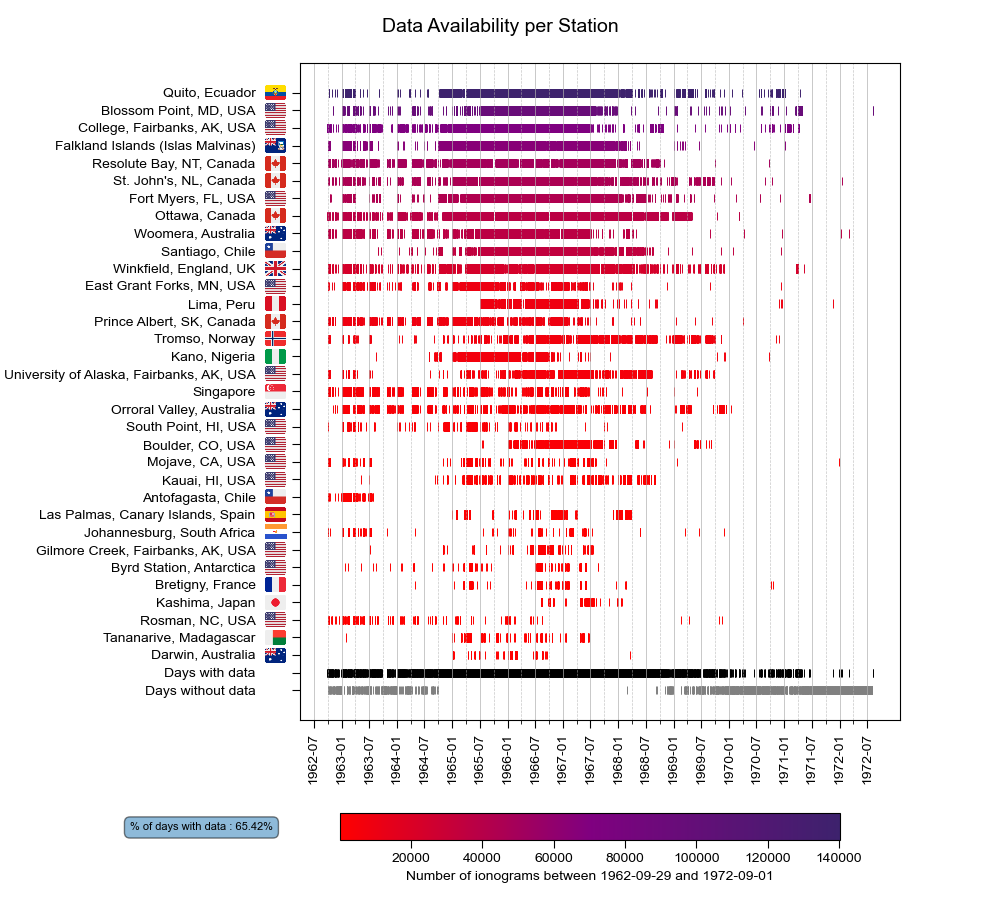

In [47]:
fig = availabilityPlot(df,'19620929','19720901','Data Availability per Station',cmap=redpurple)
# Command to save figure
fig.savefig('data_availability_Alouette.png')

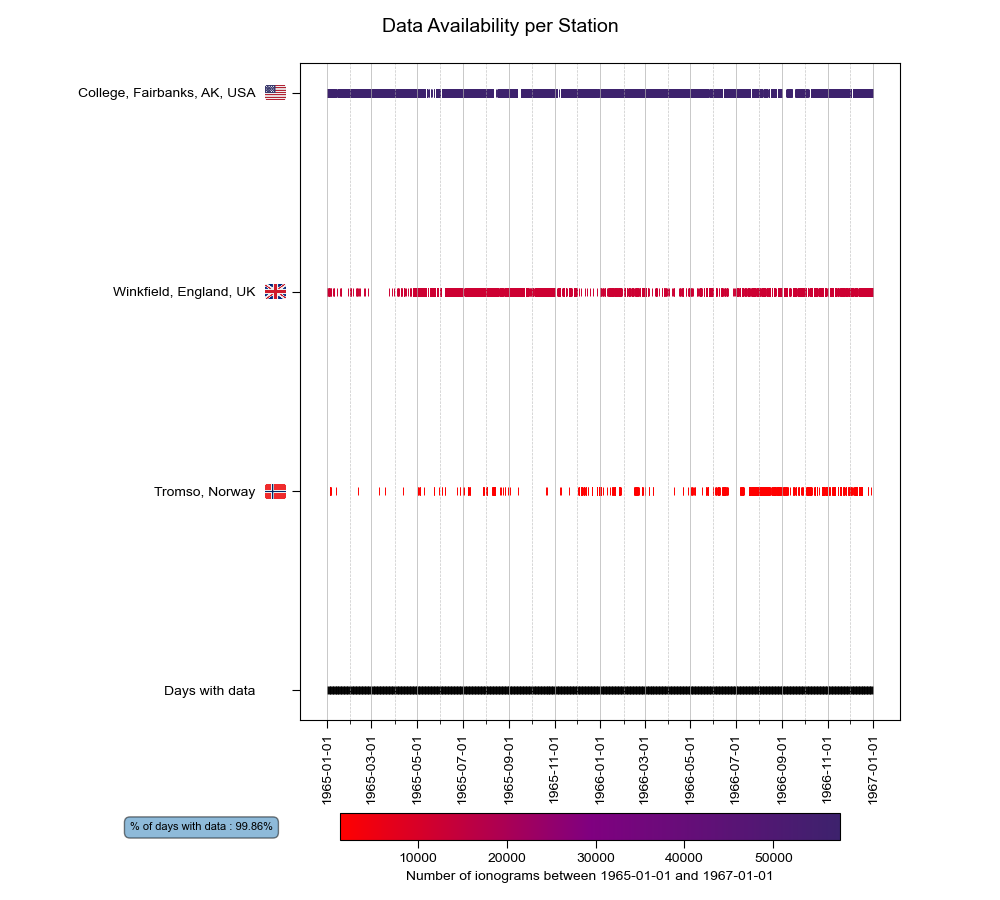

In [48]:
#Only the COL, TRO and WNK stations
fig = availabilityPlot(df,'19650101','19670101','Data Availability per Station',
                       cmap=redpurple, stationCode=['COL','TRO','WNK'])

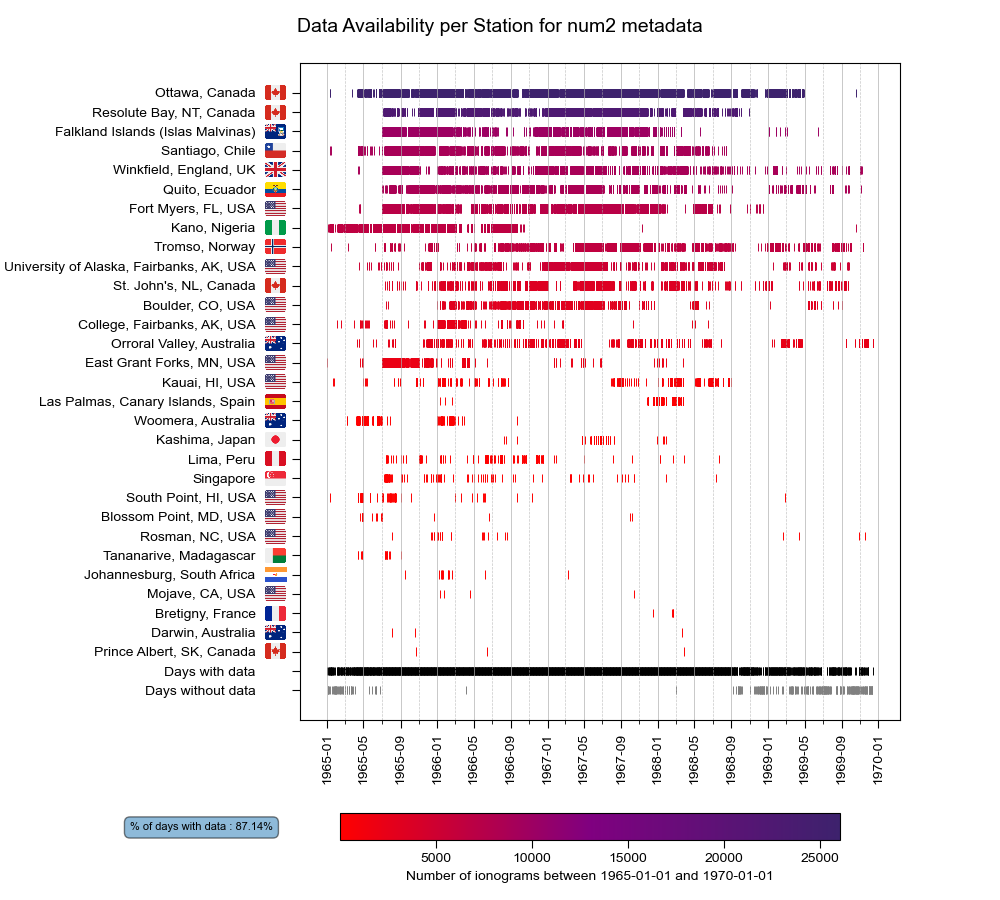

In [49]:
# Only num2 metadata
fig = availabilityPlot(df,'19650101','19700101','Data Availability per Station for num2 metadata',
                       cmap=redpurple, metaType=['num2'])

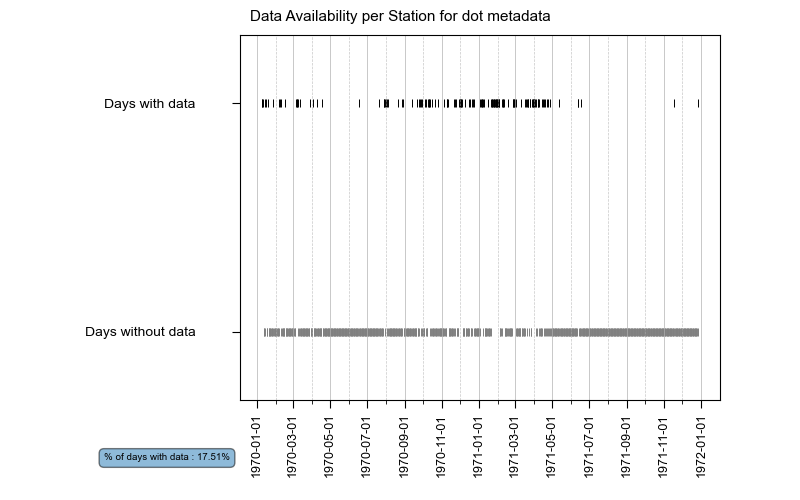

In [50]:
# Only days with and without data
# Need to make some layout changes for better display
mpl.rcParams['figure.figsize']=(8,5)
mpl.rcParams['font.size']=7 #Size of text in box
mpl.rcParams['figure.titlesize']=11 #The title
mpl.rcParams['ytick.labelsize']=10
mpl.rcParams['xtick.labelsize']=9 #Size of the dates on the x-axis and the numbers of the colorbar
fig = availabilityPlot(df,'19700101','19720101',
                       'Data Availability per Station for dot metadata',stationCode=None)